In [1]:
#!!pip install tweepy==3.10.0
#!!pip install wordcloud
#!!pip install decorator==5.0.9
#!!pip install --user networkx==2.3
#!!pip install spacy
#!!pip install vaderSentiment
#!!pip install nltk gensim pyLDAvis
#!!pip install transformers
#!!python -m spacy download en_core_web_sm
#!!pip install bertopic
#!!pip install --upgrade transformers

In [63]:
import os
import time
import re
import datetime
import warnings
import spacy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from nltk.sentiment import SentimentIntensityAnalyzer as NLTKSentimentIntensityAnalyzer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer as VADERSentimentIntensityAnalyzer
from transformers import pipeline
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from textblob import TextBlob
import gensim
from gensim import corpora
from gensim.utils import simple_preprocess
import pyLDAvis
import pyLDAvis.gensim

import nltk
nltk.download('vader_lexicon')
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from gensim.models import LdaModel
from nltk.tokenize import word_tokenize
nltk.download('punkt')

# Set stop words
stop_words = set(stopwords.words('english'))

# Pandas display options
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', None)

# Suppress warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/sinegugumthembu/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sinegugumthembu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/sinegugumthembu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/sinegugumthembu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Data from Sibukele as part of the Python Masterclass for Data Science by NEMISA (Feb 2025) 

In [15]:
tweets = pd.read_csv('https://raw.githubusercontent.com/sibukele/sa_tweets/main/twitter_sentiment_data.csv', sep = ",")
tweets.head()

sentiment                                                                                                                                             message             tweetid
0         -1           @tiniebeany climate change is an interesting hustle as it was global warming but the planet stopped warming for 15 yes while the suv boom  792927353886371840
1          1  RT @NatGeoChannel: Watch #BeforeTheFlood right here, as @LeoDiCaprio travels the world to tackle climate change https://t.co/LkDehj3tNn httÃ¢â‚¬Â¦  793124211518832641
2          1                               Fabulous! Leonardo #DiCaprio's film on #climate change is brilliant!!! Do watch. https://t.co/7rV6BrmxjW via @youtube  793124402388832256
3          1     RT @Mick_Fanning: Just watched this amazing documentary by leonardodicaprio on climate change. We all think thisÃ¢â‚¬Â¦ https://t.co/kNSTE8K8im  793124635873275904
4          2         RT @cnalive: Pranita Biswasi, a Lutheran from Odisha, gives testimony on effects of climate change &amp; natural disasters on the poÃ¢â‚¬Â¦  793125156185137153

In [16]:
tweets.describe()

sentiment       tweetid
count  43943.000000  4.394300e+04
mean       0.853924  8.367966e+17
std        0.853543  8.568506e+16
min       -1.000000  5.926334e+17
25%        0.000000  7.970376e+17
50%        1.000000  8.402301e+17
75%        1.000000  9.020003e+17
max        2.000000  9.667024e+17

In [17]:
tweets['message']

0                 @tiniebeany climate change is an interesting hustle as it was global warming but the planet stopped warming for 15 yes while the suv boom
1        RT @NatGeoChannel: Watch #BeforeTheFlood right here, as @LeoDiCaprio travels the world to tackle climate change https://t.co/LkDehj3tNn httÃ¢â‚¬Â¦
2                                     Fabulous! Leonardo #DiCaprio's film on #climate change is brilliant!!! Do watch. https://t.co/7rV6BrmxjW via @youtube
3           RT @Mick_Fanning: Just watched this amazing documentary by leonardodicaprio on climate change. We all think thisÃ¢â‚¬Â¦ https://t.co/kNSTE8K8im
4               RT @cnalive: Pranita Biswasi, a Lutheran from Odisha, gives testimony on effects of climate change &amp; natural disasters on the poÃ¢â‚¬Â¦
                                                                                ...                                                                        
43938                                  Dear @realDonaldTrump,\nY

### Function to Clean Tweets

In [18]:
def clean_text(df, text_field):
    # Remove URLs
    df[text_field] = df[text_field].str.replace(r"http\S+|www\S+|https\S+", "", regex=True)  # Remove URLs
    
    # Remove @ mentions and replace with 'at'
    df[text_field] = df[text_field].str.replace(r"@\w+", "at", regex=True)  # Replace @mentions with 'at'
    
    # Remove any character that is not a letter, number, or specified punctuation
    df[text_field] = df[text_field].str.replace(r"[^A-Za-z0-9(),!?\'\`\"\_\n]", " ", regex=True)
    
    # Convert to lowercase
    df[text_field] = df[text_field].str.lower()
    
    # Remove extra whitespace
    df[text_field] = df[text_field].str.replace(r"\s+", " ", regex=True).str.strip()  # Remove extra spaces
    
    return df

### Generating a word cloud in order to visually represent the most frequent words in the dataset

In [19]:
clean_text(tweets,'message')

sentiment                                                                                                                           message             tweetid
0             -1  at climate change is an interesting hustle as it was global warming but the planet stopped warming for 15 yes while the suv boom  792927353886371840
1              1                                       rt at watch beforetheflood right here, as at travels the world to tackle climate change htt  793124211518832641
2              1                                              fabulous! leonardo dicaprio's film on climate change is brilliant!!! do watch via at  793124402388832256
3              1                               rt at just watched this amazing documentary by leonardodicaprio on climate change we all think this  793124635873275904
4              2       rt at pranita biswasi, a lutheran from odisha, gives testimony on effects of climate change amp natural disasters on the po  793125156185137153
...          ...                                                                                                                               ...                 ...
43938          1                                                       dear at, yeah right human mediated climate change is a chinese urban legend  791307031919550464
43939          1                                                what will your respective parties do to prevent climate change globally? zpndebate  791316857403936768
43940          2                                                           rt at un poll shows climate change is the lowest of all global concerns  791357509101621249
43941          0        rt at i still can q t believe this gif of taehyung saved the human race, stopped global warming and watered every plant on  791390042136641537
43942          1              at at the wealthy fossil fuel industry know climate change is real their money is to make sure they are safe from it  791401610308038656

[43943 rows x 3 columns]

In [20]:
# join tweets to a single string
words = ' '.join(tweets['message'])
words


"at climate change is an interesting hustle as it was global warming but the planet stopped warming for 15 yes while the suv boom rt at watch beforetheflood right here, as at travels the world to tackle climate change htt fabulous! leonardo dicaprio's film on climate change is brilliant!!! do watch via at rt at just watched this amazing documentary by leonardodicaprio on climate change we all think this rt at pranita biswasi, a lutheran from odisha, gives testimony on effects of climate change amp natural disasters on the po unamshow awache kujinga na iko global warming rt at pranita biswasi, a lutheran from odisha, gives testimony on effects of climate change amp natural disasters on the po rt at presidential candidate donaldtrump is dangerous on climate change, says monaco s prince albert rt at leonardo dicaprio's climate change documentary is free for a week indigenous tairp beforetheflood watch beforetheflood right here, as at travels the world to tackle climate change rt at it's v

In [21]:
tweets['message']

0        at climate change is an interesting hustle as it was global warming but the planet stopped warming for 15 yes while the suv boom
1                                             rt at watch beforetheflood right here, as at travels the world to tackle climate change htt
2                                                    fabulous! leonardo dicaprio's film on climate change is brilliant!!! do watch via at
3                                     rt at just watched this amazing documentary by leonardodicaprio on climate change we all think this
4             rt at pranita biswasi, a lutheran from odisha, gives testimony on effects of climate change amp natural disasters on the po
                                                                       ...                                                               
43938                                                         dear at, yeah right human mediated climate change is a chinese urban legend
43939                             

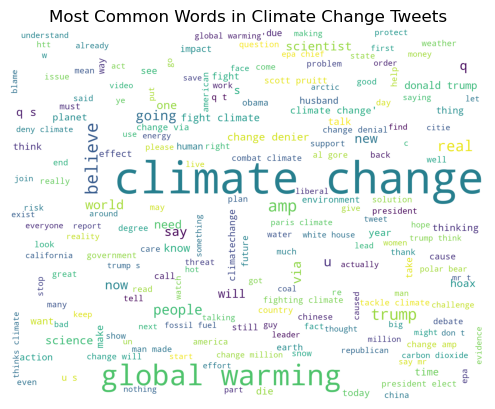

In [25]:
from wordcloud import WordCloud, STOPWORDS
no_urls_no_tags = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'rt'
                            ])
wordcloud = WordCloud(
                      stopwords=STOPWORDS,
                      background_color='white',
                      width=1800,
                      height=1400
                     ).generate(no_urls_no_tags)
plt.axis("off")
plt.title("Most Common Words in Climate Change Tweets")
plt.imshow(wordcloud)
plt.axis('off')
plt.savefig('./my_twitter_wordcloud_1.png', dpi=300)
plt.show()

#### The word cloud analysis of climate change tweets reveals that the most frequently used words are "climate change", followed by "global warming," "believe," and "science." This suggests that discussions around climate change often center on its terminology, public perception, and scientific discourse. The prominence of "believe" indicates ongoing debates about climate change, while "science" highlights the role of scientific evidence in these conversations. Trump is an unexpected pop up but none the less interesting.

## SENTIMENT ANALYSIS
### Now classifying tweets as Positive, Negative, or Neutral using VADER (Valence Aware Dictionary and sEntiment Reasoner)

In [29]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

# Function to classify sentiment
def get_sentiment(text):
    score = analyzer.polarity_scores(text)['compound']
    if score >= 0.05:
        return "Positive"
    elif score <= -0.05:
        return "Negative"
    else:
        return "Neutral"

In [30]:
# Apply sentiment analysis to the dataset
tweets['Sentiment'] = tweets['message'].apply(get_sentiment)

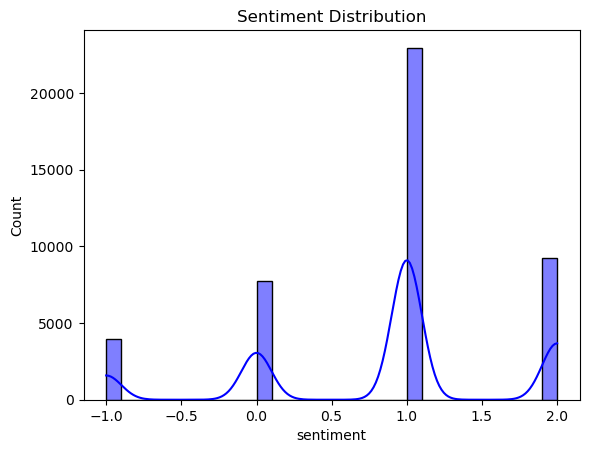

In [31]:
# Plot Sentiment Distribution
sns.histplot(tweets['sentiment'], bins=30, kde=True, color='blue')
plt.title('Sentiment Distribution')
plt.show()

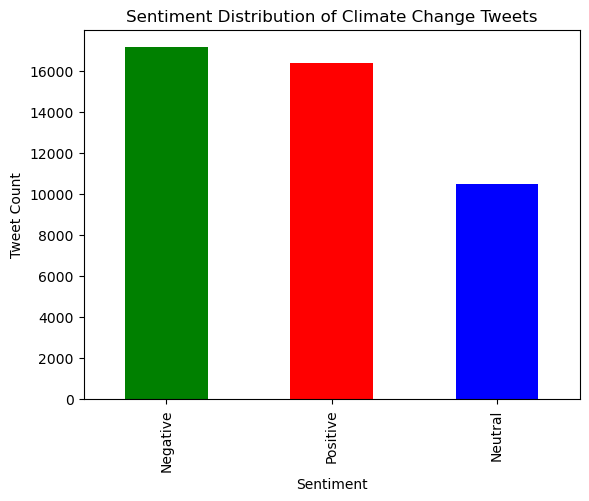

In [32]:
tweets['Sentiment'].value_counts().plot(kind='bar', color=['green', 'red', 'blue'])
plt.title("Sentiment Distribution of Climate Change Tweets")
plt.xlabel("Sentiment")
plt.ylabel("Tweet Count")
plt.show()

### Printing some of the tweets to see how well VADER clasifies them.

In [33]:
print(tweets[tweets['Sentiment'] == "Positive"]['message'].sample(10).tolist())


['rt at compelling infographic on what is and isn t happening in climate change from the excellent at cleangrowthstrate', 'conversations by top climate change influencers in the last week', 'rt at denying science the science of climate change is now an article of faith for white american evangelicals', 'at antarctic iceberg will help save the world from climate change, feeding billions of fish, read how', "harvard is 'pausing' their investments in fossil fuels here's how that can help pause climate change", 'at yipee!! may be the last re global warming tell daddy what he clearly does not know', 'i certainly agree 2 the climate change argument, interconnectedness is not a threat', 'rt at scientists from 13 agencies have written a climate report that bucks claims that global warming may be natural', "at global warming always been an 'issue' though", 'rt at call us epa administrator scott pruitt 1 202 564 4700 and tell him global warming is real and is due to co2 emissions']


In [34]:
print(tweets[tweets['Sentiment'] == "Negative"]['message'].sample(10).tolist())


["another day tomorrow just talk about it paris climate change agreement ronald mcdonald sucks and hillary isn't an activist just a stupid", "rt at at the earth fired a warning shot across his bow over climate change earth 'nice building you got there", "rt at still can't believe our new president is a moron who believes global warming is a hoax", 'rt at scott pruitt s office deluged with angry callers after he questions the science of global warming washington post', "the 'skeptical environmentalist' takes on climate change in the controversial doc, cool it", "rt at dispute it prove climate change is caused by humans i'll wait", 'rt at the holocene climate experience and the health risks climate change carries via', 'we now know whales help halt climate change what is the real reason for japans ocean assault? opwhales', 'rt at the leaked report says australia is not on track to meet the paris climate change commitments and that investment in th', "trump's white house website is one ye

### Climate change tweets show more negative sentiment, which aligns with the general concern and urgency around the topic. A significant number of positive tweets exist, likely due to activism, solutions, or supportive messages. Further improvements in sentiment analysis can refine classification, especially by accounting for sarcasm, mixed sentiments, and deeper language context.

## Topic Modeling (LDA)

In [35]:
tweets.head()

sentiment                                                                                                                           message             tweetid Sentiment
0         -1  at climate change is an interesting hustle as it was global warming but the planet stopped warming for 15 yes while the suv boom  792927353886371840  Positive
1          1                                       rt at watch beforetheflood right here, as at travels the world to tackle climate change htt  793124211518832641   Neutral
2          1                                              fabulous! leonardo dicaprio's film on climate change is brilliant!!! do watch via at  793124402388832256  Positive
3          1                               rt at just watched this amazing documentary by leonardodicaprio on climate change we all think this  793124635873275904  Positive
4          2       rt at pranita biswasi, a lutheran from odisha, gives testimony on effects of climate change amp natural disasters on the po  793125156185137153  Negative

In [65]:
print(STOPWORDS)  # Displays the default set of stopwords, I was just wondering what they are.

{'some', "he'll", "weren't", 'yourself', "i've", 'with', 'after', "i'll", 'down', 'than', 'from', 'here', "you'll", "let's", 'or', 'to', 'your', 'own', 'not', 'cannot', 'yours', 'like', 'this', 'under', 'was', 'then', 'when', 'whom', 'ought', 'they', 'be', 'com', 'only', 'that', 'too', 'below', "can't", 'also', 'otherwise', "how's", 'at', 'therefore', "there's", "he'd", "we've", "we'd", 'for', 'since', 'is', 'both', "isn't", 'else', "she'd", "she's", 'these', 'above', 'we', 'him', 'about', 'does', "i'm", 'did', 'further', 'my', 'over', 'i', 'against', 'theirs', 'he', "doesn't", "didn't", "she'll", 'off', 'but', 'myself', 'our', 'k', "we're", "we'll", 'having', 'www', "you're", 'by', 'how', 'hers', 'a', 'been', "aren't", 'who', 'ourselves', 'into', "haven't", "what's", 'once', "mustn't", "here's", 'should', 'just', "they'll", 'himself', 'there', 'ever', 'through', "couldn't", 'because', 'however', 'what', 'of', 'more', 'as', 'doing', 'yourselves', 'you', 'me', 'out', "shan't", 'are', "w

In [56]:
def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    tokens = simple_preprocess(text)  # Tokenize words
    tokens = [word for word in tokens if word not in stop_words] 
    return tokens
custom_stopwords = ["climate", "change", "rt"]  
tweets['tokens'] = tweets['tokens'].apply(lambda x: [word for word in x if word not in custom_stopwords])


dictionary = corpora.Dictionary(tweets['tokens'])  
corpus = [dictionary.doc2bow(text) for text in tweets['tokens']]  # Convert to Bag-of-Words

In [57]:
num_topics = 4  # Change this to find the best number
lda_model = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=10)

In [60]:
for idx, topic in lda_model.print_topics(-1):
    print(f"Topic {idx}: {topic}\n")

Topic 0: 0.032*"trump" + 0.012*"via" + 0.010*"paris" + 0.009*"says" + 0.009*"obama" + 0.009*"new" + 0.007*"epa" + 0.007*"donald" + 0.006*"fight" + 0.006*"also"

Topic 1: 0.015*"world" + 0.012*"amp" + 0.009*"could" + 0.008*"via" + 0.007*"new" + 0.006*"action" + 0.006*"us" + 0.006*"take" + 0.005*"fight" + 0.005*"right"

Topic 2: 0.102*"global" + 0.094*"warming" + 0.011*"real" + 0.005*"weather" + 0.005*"think" + 0.004*"like" + 0.004*"earth" + 0.004*"know" + 0.004*"health" + 0.004*"made"

Topic 3: 0.017*"people" + 0.014*"believe" + 0.010*"amp" + 0.010*"say" + 0.007*"going" + 0.006*"like" + 0.005*"energy" + 0.005*"oil" + 0.005*"dont" + 0.005*"real"



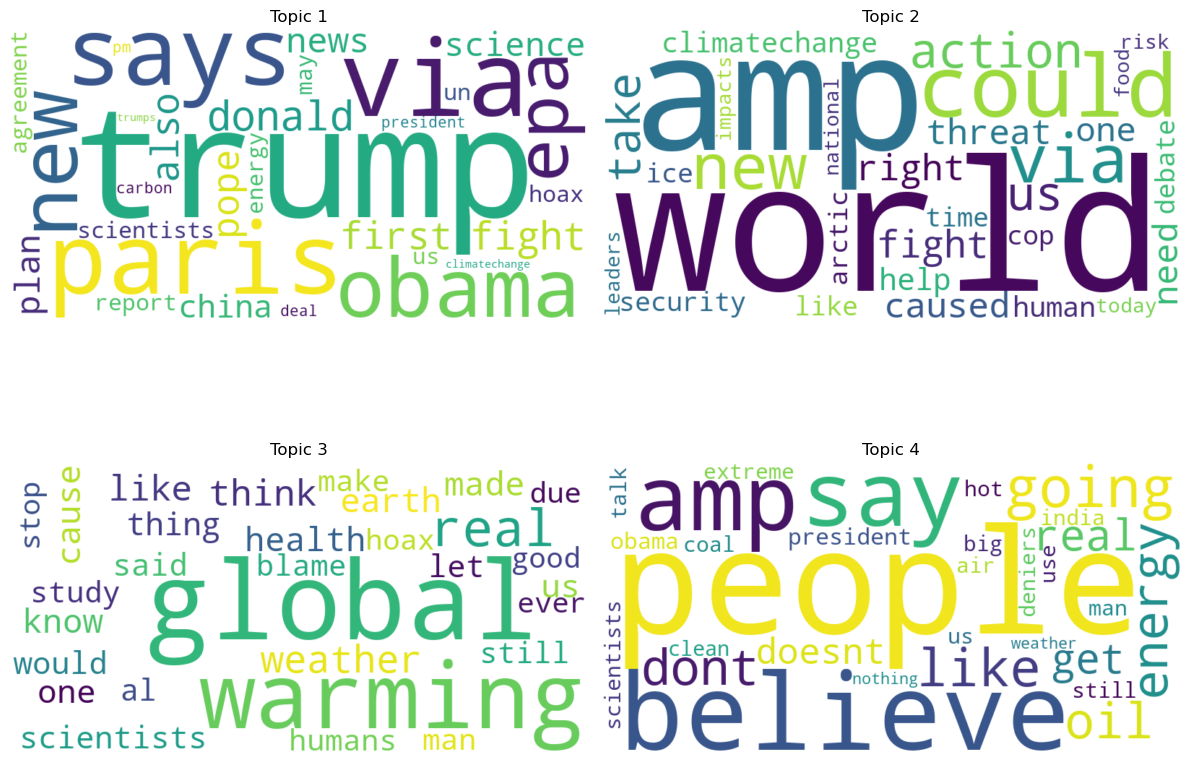

In [61]:
num_words = 30  # Number of words per topic
num_topics = 4 

fig, axes = plt.subplots(2, 2, figsize=(12, 10)) 
axes = axes.flatten()  

for topic_num in range(num_topics):
    topic_words = dict(lda_model.show_topic(topic_num, num_words))
    
    # Generate word cloud
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(topic_words)
    
    # Plot in subplots
    axes[topic_num].imshow(wordcloud, interpolation="bilinear")
    axes[topic_num].axis("off")
    axes[topic_num].set_title(f"Topic {topic_num+1}")

plt.tight_layout()
plt.show()

### Named Entity Recognition (NER) → Extract Names, Locations & Organizations

In [70]:
# NAMED ENTITY RECOGNITION (NER) using spaCy
nlp = spacy.load("en_core_web_sm")
def extract_named_entities(text):
    doc = nlp(text)
    return [(ent.text, ent.label_) for ent in doc.ents]

tweets['named_entities'] = tweets['message'].apply(extract_named_entities)
print(tweets[['message', 'named_entities']].head())


                                                                                                                            message                              named_entities
0  at climate change is an interesting hustle as it was global warming but the planet stopped warming for 15 yes while the suv boom                            [(15, CARDINAL)]
1                                       rt at watch beforetheflood right here, as at travels the world to tackle climate change htt                                          []
2                                              fabulous! leonardo dicaprio's film on climate change is brilliant!!! do watch via at             [(leonardo dicaprio's, PERSON)]
3                               rt at just watched this amazing documentary by leonardodicaprio on climate change we all think this                                          []
4       rt at pranita biswasi, a lutheran from odisha, gives testimony on effects of climate change amp natural disaster

In [71]:
from collections import Counter
# Extract Named Entities
locations = []
organizations = []
people = []

for entities in tweets["named_entities"]:
    for ent, label in entities:
        if label == "GPE":  # Geopolitical Entities (Countries, Cities, etc.)
            locations.append(ent)
        elif label == "ORG":  # Organizations
            organizations.append(ent)
        elif label == "PERSON":  # People
            people.append(ent)

# Count top entities
top_locations = Counter(locations).most_common(10)
top_organizations = Counter(organizations).most_common(10)
top_people = Counter(people).most_common(10)

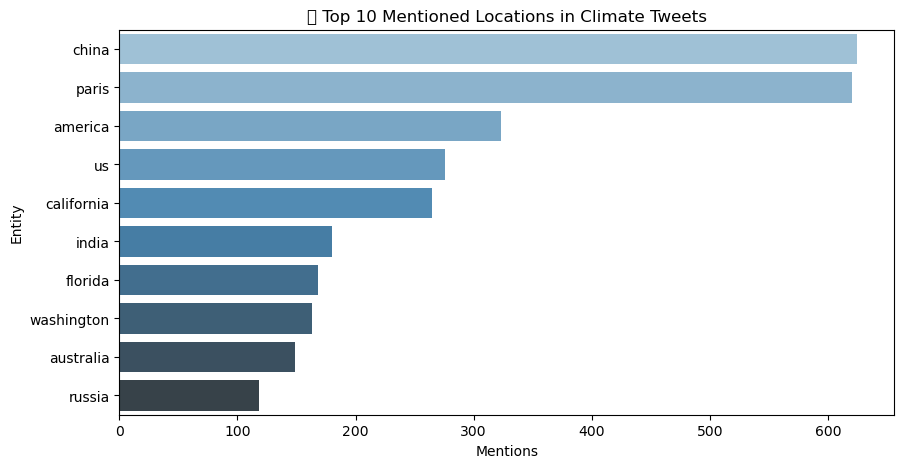

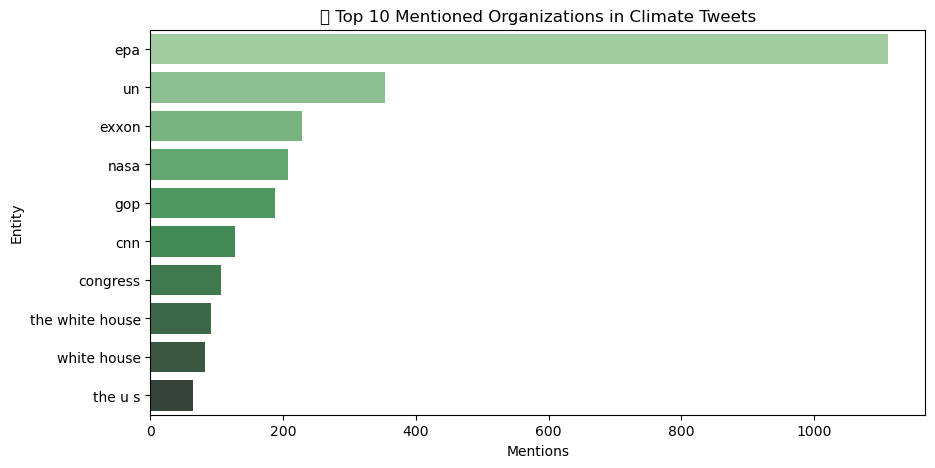

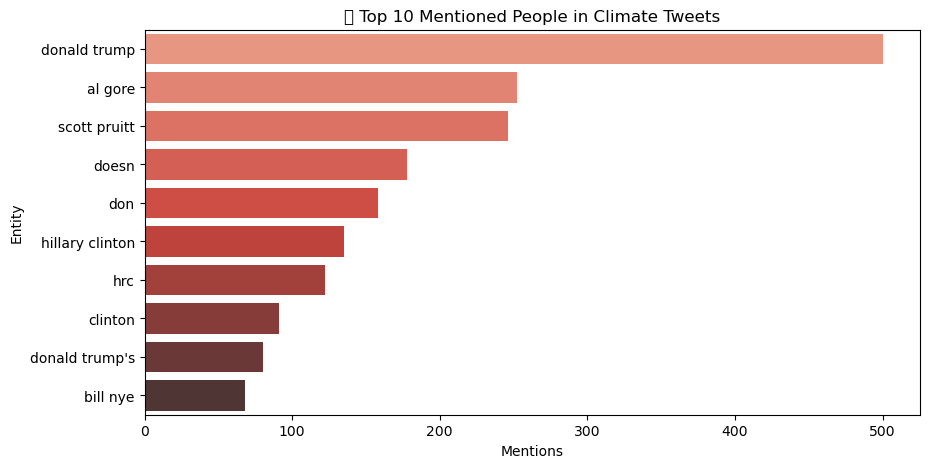

In [72]:
def plot_top_entities(entity_counts, title, color):
    entity_names, entity_values = zip(*entity_counts)
    
    plt.figure(figsize=(10, 5))
    sns.barplot(x=list(entity_values), y=list(entity_names), palette=color)
    
    plt.xlabel("Mentions")
    plt.ylabel("Entity")
    plt.title(title)
    plt.savefig("top_entities.png", dpi=300)
    plt.show()

# Plot Top Locations, Organizations, and People
plot_top_entities(top_locations, "🌍 Top 10 Mentioned Locations in Climate Tweets", "Blues_d")
plot_top_entities(top_organizations, "🏢 Top 10 Mentioned Organizations in Climate Tweets", "Greens_d")
plot_top_entities(top_people, "👤 Top 10 Mentioned People in Climate Tweets", "Reds_d")

## Generate Short Summaries of Tweets Using T5

In [76]:
# TEXT SUMMARIZATION using Hugging Face Transformers
t5_summarizer = pipeline("summarization", model="t5-small")
def summarize_text(text):
    if len(text.split()) > 50:  # Only summarize longer tweets
        return t5_summarizer(text, max_length=50, min_length=20, do_sample=False)[0]['summary_text']
    return text

tweets['summary'] = tweets['message'].apply(summarize_text)
print(tweets[['message', 'summary']].head())

# Save Processed Data
tweets.to_csv("processed_climate_tweets.csv", index=False)


Device set to use mps:0


                                                                                                                            message                                                                                                                           summary
0  at climate change is an interesting hustle as it was global warming but the planet stopped warming for 15 yes while the suv boom  at climate change is an interesting hustle as it was global warming but the planet stopped warming for 15 yes while the suv boom
1                                       rt at watch beforetheflood right here, as at travels the world to tackle climate change htt                                       rt at watch beforetheflood right here, as at travels the world to tackle climate change htt
2                                              fabulous! leonardo dicaprio's film on climate change is brilliant!!! do watch via at                                              fabulous! leonardo dicaprio's film on